# How Anxcor uses XArray to simplify timeseries operations
## Part III.  Advanced Signal Processing

So far we've seen that Anxcor can do a number of small, yet common, processing techniques. In this section we'll introduce data adaptive processing functions which utilize rolling windows.  We'll also introduce the ```XArrayProcessor``` interface, which allows users to craft their own signal processing routines.

Lets start with the basic signal processing stack of data->resample->remove mean trend. I'll use the same data querying from Part II.

In [13]:
from anxcor.xarray_routines import XArrayConverter, XArrayResample, XArrayRemoveMeanTrend
from anxcor.anxcor_utils import remove_response
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
%matplotlib inline

client = Client("IRIS")
t  = UTCDateTime("2018-12-25 12:00:00").timestamp
st = client.get_waveforms("UU", "SPU", "*", "H*", t, t + 60*60,attach_response=True)
st.detrend(type='linear')
st.detrend(type='constant')
st.taper(0.05)
pre_filt = (0.03, 0.05, 40.0, 45.0)
st=remove_response(st, output='DISP', pre_filt=pre_filt)
st

/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


3 Trace(s) in Stream:
UU.SPU.01.HHE | 2018-12-25T12:00:00.000000Z - 2018-12-25T13:00:00.000000Z | 100.0 Hz, 360001 samples
UU.SPU.01.HHN | 2018-12-25T12:00:00.000000Z - 2018-12-25T13:00:00.000000Z | 100.0 Hz, 360001 samples
UU.SPU.01.HHZ | 2018-12-25T12:00:00.000000Z - 2018-12-25T13:00:00.000000Z | 100.0 Hz, 360001 samples

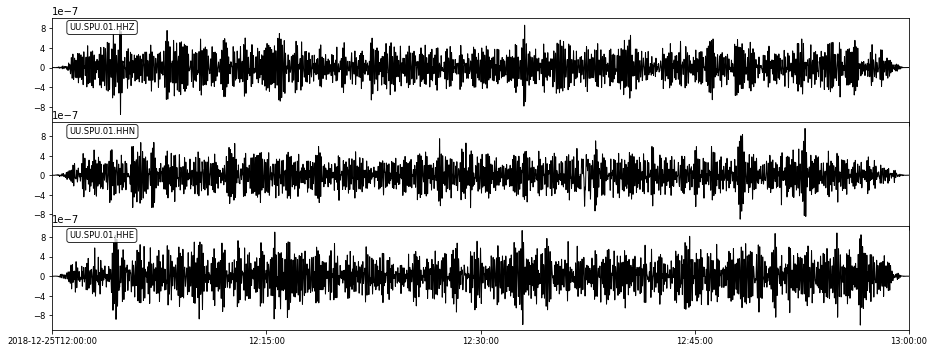

In [11]:
fig=plt.figure(figsize=(14,5))
st.plot(fig=fig)
plt.show()

Everything seems to be in order, so lets convert the stream, resample to 10 Hz, and remove the mean and trend

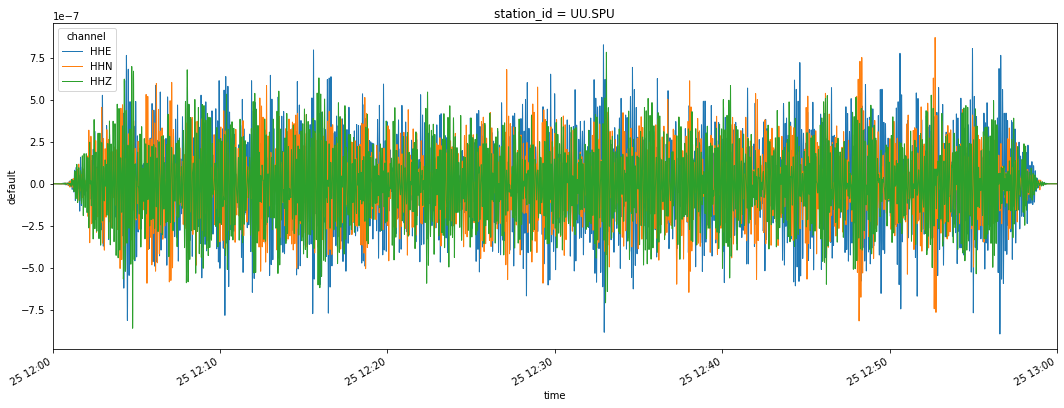

In [12]:
converter = XArrayConverter()
resampler = XArrayResample(target_rate=10.0)
rmmean_trend= XArrayRemoveMeanTrend()

xarray          = converter(st)
resampled_array = resampler(xarray)
rmm_array       = rmmean_trend(resampled_array)
xarray_squeezed = rmm_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

### Rolling Window Processing Design

Rolling window techniques, of which temporal normalization (and sometimes whitening) are a subset, aim to reduce the effect of earthquakes and monochromatic sources. Bensen et al (2007), identified temporal normalization as the single most important technique in single station-data preparation. Their paper is an excellent overview of the signal processing stack needed for Seismic Ambient Noise Crosscorrelation, and I highly reccomend reading it.

Currently, Anxcor provides two rolling window processing classes for this purpose: ```XArrayWhiten``` and ```XArrayTemporalNorm```. 

All derived rolling window classes can be subdivided into two categories:
* **Single Rolling series-to-all channel (SRC)**. A single timeseries rolling window series is derived from all channels to be applied to all channels.
* **Rolling channel-to-channel (RCC)**. Each individual channel produces a rolling window series to apply to itself

In both cases the process starts with deriving a rolling window metric from each channel. The input channels $X_1(t), X_2(t), X_3(t)$ are transformed into corresponding metrics $R_1(t), R_2(t), R_3(t)$. A function $f_1(X(t_i), X(t_{i+1}),...X(t_{i+n}))$ transforms a variable number of input $X(t_i)$'s into $R(t_i)$'s.

 All $f_1(X(t_i), X(t_{i+1}),...X(t_{i+n}))$ require two general classes of parameters to define: 
 
 * **Window assignment** The length of the window $n$, and whether to assign the result of the rolling operation to the beginning of the window $X(t_i) \rightarrow R(t_i)$ or the middle of the window $X(t_i) \rightarrow R(t_{\frac{i+n}{2}})$.
 
 * **Window operation** Any of 'max', 'min', 'mean', or 'median'. **All window operations operate on the absolute value of the given window to prevent divide by zero errors.**
 
 
 The result of this strict indice definition can leave NaN values in the target rolling window array $R(t_i)$. Anxcor resolves this by filling those values with the nearest non NaN values.
 
After the metrics $R_i(t)$ have been created, and if the **RCC** method is chosen, the output of this type of processor is simply

$X^{'}_j(t_i) = \frac{X_j(t_i)}{ R_j(t_i)}$

The **SRC** method may be preferrable if it is desireable to keep relative component amplitude. In this case, a metric is used to convert all the $R_j(t_i)$s to a single normalizing series $S(t_i)$. This metric can be any of 'max', 'min', 'mean', or 'median'. In the **SRC** case the output channels are defined as:

$X^{'}_j(t_i) = \frac{X_j(t_i)}{ S(t_i)}$

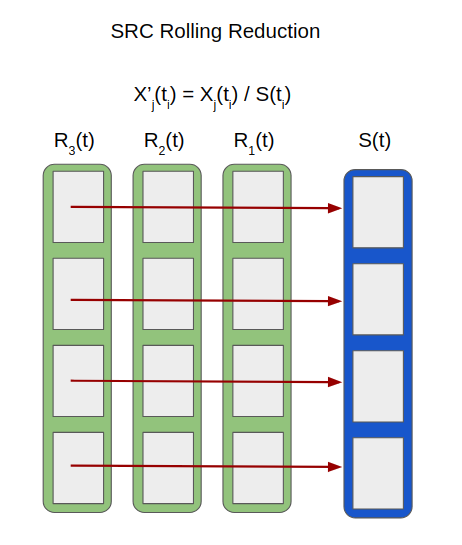

In [5]:
x = Image(filename='rolling_reduction.png')
display(x)

Anxcor provides the XArrayRolling superclass as a way to standardize rolling processing functions. All derived classes must pass the following kwargs:

* **window=1.0**. float. Variable representing the rolling window length. By default child classes interpret this as the rolling window in seconds.

* **approach='rcc'**. str. Which rolling approach to use. Either ```'src'``` for rolling window-channel reduction to a single channel, or ```'rcc'``` for rolling channel-to-channel

* **center=True**. bool. If ```True```, assigns the result of the rolling operation to the center of the window. Else, assigns it to the beginning.

* **rolling_metric='mean'**. str. Can be any of ```'mean'```, ```'median'```, ```'min'```, or ```'max'```. Defines the rolling operation **R(t)** to do. $X_j(t_i)->R_j(t_i)$

* **reduce_metric='mean'**. str.  Can be any of ```'mean'```, ```'median'```, ```'min'```, or ```'max'```. Defines the rolling series reduction operation **S(t)** to do. $f(R_0(t_i),R_1(t_i),R_2(t_i))=S(t_i)$


The XArrayRolling class provides five methods to allow intermediate rolling-type processing of xarrays:

* ```_preprocess(self,xarray):``` Routine for preprocessing data prior to rolling and dividing procedures. Defaults to returing xarray.

* ```_pre_rolling_process(self,pre_processed_xarray, xarray):``` Routine for preprocessing data prior to rolling operations. Defaults to returing xarray.

* ```_get_rolling_samples(self,processed_array, xarray):``` Routine for calculating the sample interval to roll over. Inputs are the processed array, and the original array. Must return an int. Defaults to ```int(1.0/xarray.attrs['delta'])```.

* ```_post_rolling_process(self,rolled_array, xarray):``` Routine for processing the returned rolled array. arguments are the rolled array, and the original array. Defaults to returning the rolled array.

* ```_postprocess(self,normed_array, xarray):``` Routine for post-processing $X^{'}(t)$ prior to returning it to Anxcor. Defaults to returning the normed_array. Arguments are $X^{'}(t)$ (normed_array) and the original xarray.

The flowchart below illustrates the main data processing graph, and how the five functions above fit in. Note that ```_get_rolling_samples()``` is excluded as it does not return an xarray. Green boxes are the functions which are allowed to be defined by the child class.


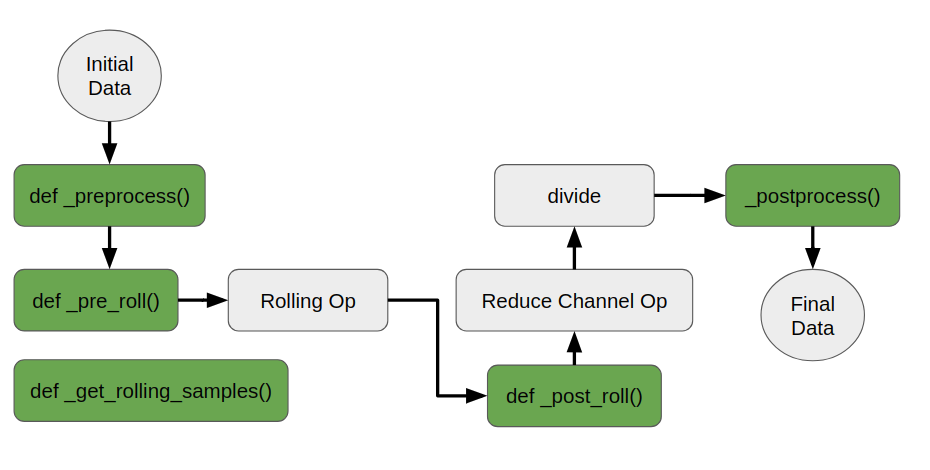

In [6]:
x = Image(filename='rolling_flow.png')
display(x)

The data dependency graph of the five defined functions is shown below.

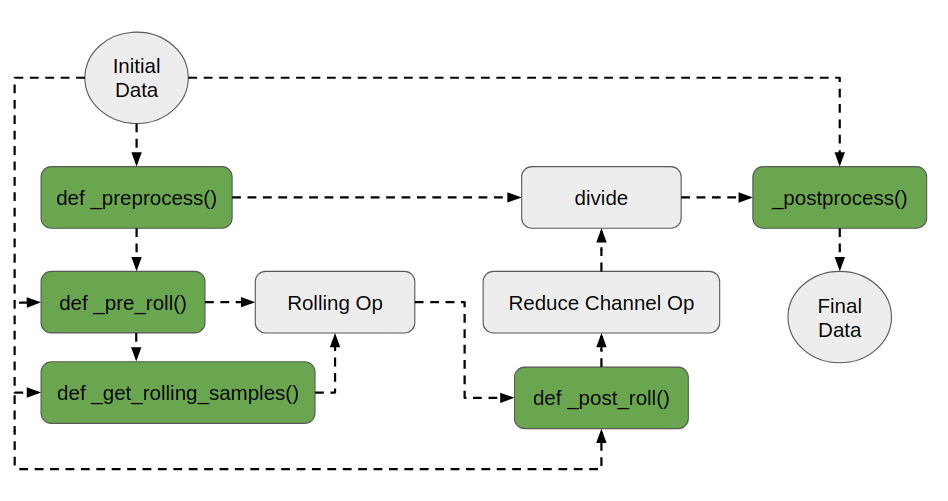

In [7]:
x = Image(filename='rolling_call_hierarchy.png')
display(x)

### Rolling Window Example:  Temporal Normalization

Lets try implementing Whitening and Temporal Normalization using the ```XArrayRolling``` class. Anxcor provides ```XArrayWhiten``` and ```XArrayTemporalNorm```, but by implementing them here we can see the full extent of functionality of ```XArrayRolling``` derived classes.

First, lets try implementing the H/V temporal normalization preservation as outlined in **Berg, E. M., et al. (2018)**. It's a fairly complicated routine, and should serve as an good example of how subclassing XArrayRolling can make such operations concise.

From the paper:

*"To obtain the temporal normalization functions, we band-pass the seismic signal
between 15- and 50-s period and calculate a 128-s time window running absolute mean for each component.
For each point in time, we divide the three-component unfiltered time series by the maximum of all temporal
normalization functions for that corresponding time across all components."*

Before performing any filtering operation with possible edge effects, remember that Anxcor tries to operate on a per-window basis. You can of course, try to pretreat the data prior to providing it to Anxcor's functions.

To modify Berg et al.'s method to work on a per-window basis, we need to ensure the rolling average and bandpass output are not considerably different at the ends of the signal. One way to do this is by artifically extending the signal by 'flipping' it forwards and backwards. Anxcor's ```filters.xarray_triple_by_reflection``` can do this for us. We'll also need to extract the normal data slice prior to dividing the original signal, therefore we'll apply Anxcor's ```filters.xarray_center_third_time``` after the rolling window operation.

So to recap, the order of operations to inversely weight our data is data$\rightarrow$triple data length$\rightarrow$bandpass between 15-50s $\rightarrow$ absolute value $\rightarrow$ anxcor's rolling ops $\rightarrow$ slice back original time window $\rightarrow$ divide original signal.

We'll also add a taper operation after everything is done.

In [15]:
import numpy as np
from anxcor.xarray_routines import XArrayRolling
import anxcor.filters as filt_ops
import xarray as xr
class XArrayTemporalNorm(XArrayRolling):
    """
    applies a temporal norm operation to an xarray timeseries 
    by first bandpassing the signal to be rolled.
    
    """

    def __init__(self,freqmin=0.01,freqmax=5.0,taper=0.1,bp_taper=1.0, **kwargs):
        super().__init__(**kwargs)
        self._kwargs['freqmin']     = freqmin
        self._kwargs['freqmax']     = freqmax
        self._kwargs['taper']       = taper


    def _pre_rolling_process(self,processed_array : xr.DataArray, xarray : xr.DataArray):
        sample_rate = 1.0 / xarray.attrs['delta']

        tripled_xarray = filt_ops.xarray_triple_by_reflection(processed_array)
        tapered        = xr.apply_ufunc(filt_ops.taper_func, tripled_xarray,
                                       input_core_dims=[['time']],
                                       output_core_dims=[['time']],
                                       kwargs={**self.get_kwargs()},
                                       keep_attrs=True)
        bp_data        = xr.apply_ufunc(filt_ops.bandpass_in_time_domain_sos,tapered,
                                       input_core_dims=[['time']],
                                       output_core_dims=[['time']],
                                       kwargs={**{'sample_rate':sample_rate},**self.get_kwargs()},
                                       keep_attrs=True)
        return abs(bp_data)

    def _post_rolling_process(self,rolled_array : xr.DataArray, xarray : xr.DataArray)-> xr.DataArray:
        original_dims = filt_ops.xarray_center_third_time(rolled_array,xarray)
        return original_dims

    def _postprocess(self, normed_array, xarray):
        filtered_array = xr.apply_ufunc(filt_ops.taper_func, normed_array,
                                        input_core_dims=[['time']],
                                        output_core_dims=[['time']],
                                        kwargs={**self._kwargs})

        return filtered_array
    
    

    def get_name(self):
        return 'temp_norm'


    def _add_operation_string(self):
        if self._kwargs['approach']=='src':
            op='temporal_norm@approach:{} ' \
               'window: {},' \
               'rolling_metric: {},' \
               'reduce_metric: {},' \
               'taper: {},' \
               'bandpass: {}<x(t)<{}'.format(
            self._kwargs['approach'],
            self._kwargs['window'],
            self._kwargs['rolling_metric'],
            self._kwargs['reduce_metric'],
            self._kwargs['taper'],
            self._kwargs['freqmin'],
            self._kwargs['freqmax'])
        else:
            op = 'temporal_norm@approach:{} ' \
                 'window: {},' \
                 'rolling_metric: {},' \
                 'taper: {},' \
                 'bandpass: {}<x(t)<{}'.format(
                self._kwargs['approach'],
                self._kwargs['window'],
                self._kwargs['rolling_metric'],
                self._kwargs['taper'],
                self._kwargs['freqmin'],
                self._kwargs['freqmax'])
        return op

Here is illustrated a basic feature of the XArrayProcessor classes, the ```self._kwargs``` dict. All parameters passed to the call signature are stored as a key-value pair in this dictionary. It is not strictly necessary to assign them to the dict keys in your constructor, but I have done so to show where they are stored.

Now, instantiate this class with the parameters needed for the **Berg, E. M., et al. (2018)** temporal normalization method, and apply them to ```rmm_array``` from the introduction.

In [17]:
t_normalizer = XArrayTemporalNorm(window=12.8,approach='rcc',center=True,rolling_metric='mean',reduce_metric='max',
                                 freqmax=1.0/15,bp_taper=0.05,
                                  freqmin=1.0/50.0,taper=0.05,order=4,zerophase=True,padtype='constant')

test_array     = rmm_array.copy()
test_array.data = np.ones(test_array.data.shape)
test_array.data*=0.001
test_array.data[0,0,:100]=1.0
t_normed_array = t_normalizer(rmm_array)

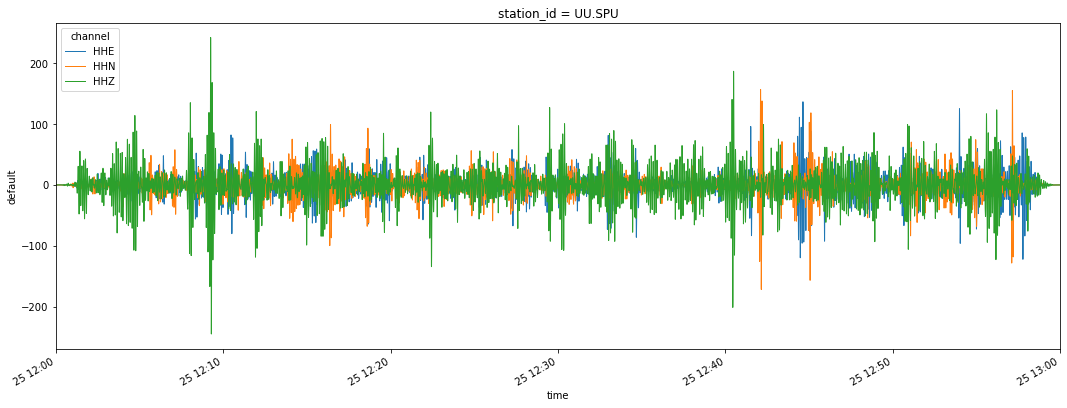

In [18]:
xarray_squeezed = t_normed_array[:,0,:].squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

an immediately noticable effect of the normalization procedure is the amplitude of the resultant waveforms. Previously, the maximum amplitude of the waveforms at the remove mean-trend step was on the order of $\mu m$s. Now, we see amplitudes $\approx\pm200$. This type of temporal normalization effectively divides a timeseries of units a by another of units a, so be careful with your interpretation of the output.

### Rolling Window Example:  Spectral Whitening

Bensen et al (2007) demonstrated that dividing the spectra by its smoothened running average reduces the effect of Earth 'hum' (Rhie J. Romanowicz 2004) and monochromatic signals. It is also useful in cross-normalizing station spectra. 

If we want to implement our own Spectral Whitening, one approach would be to take the running average of absolute frequency values, normalize our frequenices by this running average, then transform back into time domain. This is exactly what ```XArrayWhiten``` does, but we will implement it here to demonstrate how useful the ```_preprocess()``` and ```_postprocess()``` routines can be.

One complication of spectral whitening with a running mean approach is that a given time window transforms into a different value in frequency space. For our purposes we'll implement ```XArrayWhiten```'s approach, using a ratio of the original unpadded frequency spectrum length. This will happen under ```_get_rolling_samples()```.

Another complication is that, under a perfect whitening approach, the zero and very low frequencies of the signal will be enhanced. We'll use a bandpass filter in frequency space to remove them before inverting back to the time domain. This will happen under ```_postprocess()```. We'll use a fairly wide bandpass between 3Hz and 0.01Hz.

For our rolling kwargs, we'll use ```center=True```, ```approach=rcc```, and ```rolling_metric='mean'```. Also, because we are using a window ratio rather than a window of time, the ```window``` kwarg will take a value between 0 and 1. lets set it as ```window=0.005```.

In [19]:
class XArrayWhiten(XArrayRolling):
    """
    whitens the frequency spectrum of a given xarray
    """
    def __init__(self, freqmin=0.01, freqmax=5.0, order=4,zerophase=True, taper=0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self._kwargs['freqmin'] = freqmin
        self._kwargs['freqmax'] = freqmax
        self._kwargs['order'] = order
        self._kwargs['taper'] = taper
        self._kwargs['zerophase']=zerophase

    def _preprocess(self,xarray):
        fourier_array = filt_ops.xarray_time_2_freq(xarray)
        return fourier_array
    
    def _pre_rolling_process(self,processed_array, xarray):
        return abs(processed_array)

    def _postprocess(self,normed_array, xarray):
        sample_rate = 1.0/xarray.attrs['delta']
        time_domain_array = filt_ops.xarray_freq_2_time(normed_array, xarray)
        tapered_array     = xr.apply_ufunc(filt_ops.taper_func, time_domain_array,
                                            input_core_dims=[['time']],
                                            output_core_dims=[['time']],
                                            kwargs={**self._kwargs,'sample_rate':sample_rate}, keep_attrs=True)
        return time_domain_array

    def _get_rolling_samples(self,processed_xarray, xarray):
        return int(self._kwargs['window'] * xarray.data.shape[-1]/2)

    def _get_process(self):
        return 'whiten'

    def _add_operation_string(self):
        if self._kwargs['approach'] == 'src':
            op = 'Whiten@type:{} window_ratio: {},rolling_metric: {},reduce_metric: {},taper: {},bandpass: {}<x(t)<{}'.format(
                self._kwargs['approach'],
                self._kwargs['window'],
                self._kwargs['rolling_metric'],
                self._kwargs['reduce_metric'],
                self._kwargs['taper'],
                self._kwargs['freqmin'],
                self._kwargs['freqmax'])
        else:
            op = 'Whiten@type:{} window_ratio: {},rolling_metric: {},taper: {},bandpass: {}<x(t)<{}'.format(
                self._kwargs['approach'],
                self._kwargs['window'],
                self._kwargs['rolling_metric'],
                self._kwargs['taper'],
                self._kwargs['freqmin'],
                self._kwargs['freqmax'])
        return op

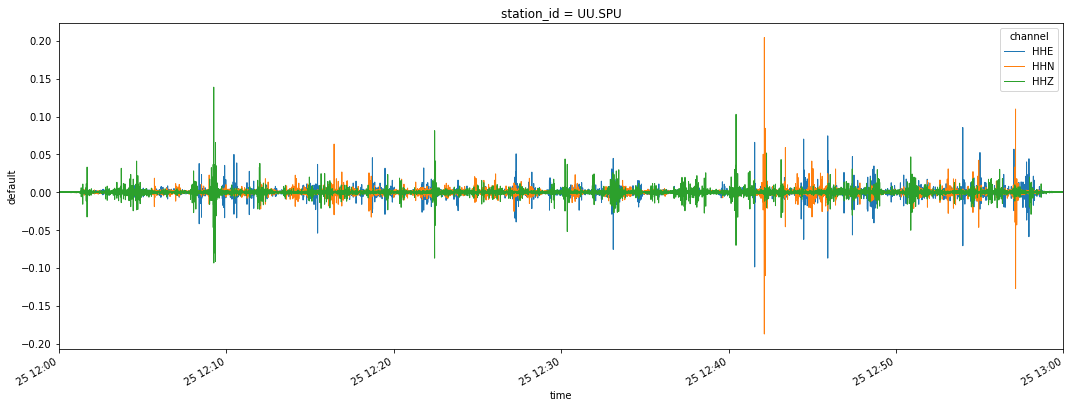

In [20]:
whitening = XArrayWhiten(center=True,window=0.005,approac='rcc',rolling_metric='max',
                         freqmin=0.01,freqmax=3.0,order=4,taper=0.05)

whitened_array  = whitening(t_normed_array)
xarray_squeezed = whitened_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

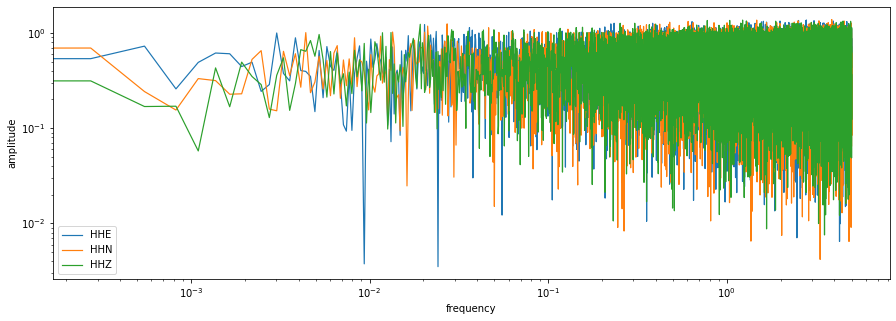

In [21]:
from scipy import fftpack
import numpy as np
bandpassed_data = whitened_array.data.squeeze()

target_length   = fftpack.next_fast_len(whitened_array.shape[-1])
frequencies     = fftpack.fftshift(fftpack.fftfreq(target_length, d=whitened_array.attrs['delta']))

fft_spectrum    = fftpack.fftshift(fftpack.fft(bandpassed_data,target_length,axis=-1))
amplitude_spectrum  = np.abs(fft_spectrum)

plt.figure(figsize=(15,5))
plt.loglog(frequencies,amplitude_spectrum[0,:],label='HHE',linewidth=1.2)
plt.loglog(frequencies,amplitude_spectrum[1,:],label='HHN',linewidth=1.2)
plt.loglog(frequencies,amplitude_spectrum[2,:],label='HHZ',linewidth=1.2)
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.legend()
plt.show()

As you can see, the frequency spectrum of the resultant waveform is basically flat. If you use this whitening approach as part of the preprocessing workflow, keep in mind that frequencies above the nyquist and near zero will be over represented. It might be a good idea to place a bandpass as well as another remove mean-trend operation after whitening.Remember, both whitening and temporal normalization are nonlinear operations and therefore the order of operations is important.

The next section will introduce you to the inheritance heirarchy of Anxcor Processor classes so you're prepared to implement them yourselves.

### References

**Bensen et al 2007**

G. D. Bensen, M. H. Ritzwoller, M. P. Barmin, A. L. Levshin, F. Lin, M. P. Moschetti, N. M. Shapiro, Y. Yang, Processing seismic ambient noise data to obtain reliable broad-band surface wave dispersion measurements, Geophysical Journal International, Volume 169, Issue 3, June 2007, Pages 1239–1260, https://doi.org/10.1111/j.1365-246X.2007.03374.x

**Berg, E. M., et al. 2018**

Berg, E. M., et al. "Tomography of Southern California via Bayesian joint inversion of Rayleigh wave ellipticity and phase velocity from ambient noise cross‐correlations." Journal of Geophysical Research: Solid Earth 123.11 (2018): 9933-9949.

**Rhie J. Romanowicz 2004**

Rhie J. Romanowicz B., 2004. Excitation of earth's incessant free oscillations by Atmosphere-Ocean-Seafloor coupling, Nature , 431, 552–556.